# PID control lab v2.7

Note: If your not farmilar with jupyter notebooks, or haven't used this in a while, please read this note. It will help you
- to run a cell press shift-enter
- A running cell will show a [\*] symbol next to it, when it is done it will have a number in the brackets
- to stop a cell from executing, press control-c

In [25]:
%matplotlib inline
from IPython.display import clear_output
import numpy as np
import time
import serial
import serial.tools.list_ports as st
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 14})
import os.path
from tqdm import tqdm

## Setup:

### Setup serial port

Connect your PID box to the computer (use the Native usb port on the Arduino. This is the micro USB port father away from the front of the box)
Run the commands below to find the appropriate Serial port for the box.
Then replace the 'xxx' with the serial port, for example 'COM4'

In [6]:
#list serial ports
ports = st.comports()
for port in ports:
    print(port)

COM4 - USB Serial Device (COM4)
COM5 - USB Serial Device (COM5)


In [7]:
#set this to the serial port of the Arduino Due
box_1 = serial.Serial('COM4', 115200, timeout=0)
box_2 = serial.Serial('COM5', 115200, timeout=0)

### Define functions for getting data and plotting

In [8]:
file_name_counter = 0;

In [9]:
def read_data(serial,last_data_point,delay_loop):
    serial.timeout = 0
    serial.write("(21,1)".encode()) # write comman
    time.sleep(0.1) # delay until command finishes writing
    line = serial.readline().decode("utf-8")
    if(line == ''):
        line = serial.readline().decode("utf-8")
        if(line == ''):
            data_array = last_data_point
            return data_array
    line_strip = line.strip('()\n')
    linearray = np.asarray(line_strip.split(','))
    data_array = linearray.astype(float)
    # if co2 is zero take last good value
    if(data_array[3]==0):
        data_array[3] = last_data_point[3]
    return data_array

def plot_data(label_array,axis_assignment,y_axis_labels,plot_mask,data_array,time_array,start_point,end_point,clear_en_flag):
    plt.figure(figsize=(14, 8))
    par0 = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)
    axis_list = list(set(np.multiply(plot_mask,axis_assignment)))
    for plot_i in range(0,len(axis_list)):
        if(axis_list[plot_i]!=0): 
            exec(f"par{axis_list[plot_i]} = par0.twinx()")
            exec(f"offset = 60*{plot_i}-40")
            exec(f"new_fixed_axis = par{axis_list[plot_i]}.get_grid_helper().new_fixed_axis")
            exec(f"par{axis_list[plot_i]}.axis['right'] = new_fixed_axis(loc='right',\
            axes=par{axis_list[plot_i]},offset=(offset, 0))")
            exec(f"par{axis_list[plot_i]}.axis['right'].toggle(all=True)")
    for data_i in range(0,len(plot_mask)):
        if(plot_mask[data_i]==1):
            exec(f"p{data_i}, = par{axis_assignment[data_i]}.plot(time_array[start_point:end_point],\
            data_array[start_point:end_point,{data_i}],\
            label=label_array[{data_i}])")
            exec(f"par{axis_assignment[data_i]}.set_ylabel(y_axis_labels[axis_assignment[{data_i}]])")
    par0.set_xlabel("Time (s)")
    par0.legend(bbox_to_anchor=(1.4+(0.1*len(axis_list)), 1.0))
    #clears out put right before each redraw to allow graph to update during execution
    if(clear_en_flag!=0):
        clear_output(wait=True)
    plt.draw()
    plt.show()
    return

def plot_data_multi_plot(label_array,axis_assignment,y_axis_labels,plot_mask,data_array_array,time_array_array,start_point,end_point,\
                  clear_en_flag):
    plt.figure(figsize=(14, 8))
    par0 = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)
    axis_list = list(set(np.multiply(plot_mask,axis_assignment)))
    
    number_of_plots = len(time_array_array)
    for plot_i in range(0,len(axis_list)):
        if(axis_list[plot_i]!=0): 
            exec(f"par{axis_list[plot_i]} = par0.twinx()")
            exec(f"offset = 60*{plot_i}-40")
            exec(f"new_fixed_axis = par{axis_list[plot_i]}.get_grid_helper().new_fixed_axis")
            exec(f"par{axis_list[plot_i]}.axis['right'] = new_fixed_axis(loc='right',\
            axes=par{axis_list[plot_i]},offset=(offset, 0))")
            exec(f"par{axis_list[plot_i]}.axis['right'].toggle(all=True)")
    for plot_set_i in range(0,number_of_plots):
        for data_i in range(0,len(plot_mask)):
            if(plot_mask[data_i]==1):
                exec(f"p{data_i}{plot_set_i}, = par{axis_assignment[data_i]}.plot(\
                time_array_array[{plot_set_i}][start_point:end_point],\
                data_array_array[{plot_set_i}][start_point:end_point,{data_i}],\
                label=label_array[{data_i}]+' (ds ' +str(plot_set_i)+')')")
                exec(f"par{axis_assignment[data_i]}.set_ylabel(y_axis_labels[axis_assignment[{data_i}]])")
    par0.set_xlabel("Time (s)")
    par0.legend(bbox_to_anchor=(1.4+(0.1*len(axis_list)), 1.0))
    #clears out put right before each redraw to allow graph to update during execution
    if(clear_en_flag!=0):
        clear_output(wait=True)
    plt.draw()
    plt.show()
    return


def save_file(file_name_counter,data_array,time_array):
    if(isinstance(time_array, int) or isinstance(time_array, float)):
        stop_time = time_array * len(data_array)
        time_array = np.linspace(0,stop_time,num =(len(data_array)+1))
    name_not_used = 0    
    while(name_not_used==0):
        filepath = "./data_saves/save_data"+str(file_name_counter)+".csv"
        if os.path.isfile(filepath):
            file_name_counter = file_name_counter + 1
        else:
            name_not_used = 1
    np.savetxt(filepath,\
           np.hstack((np.transpose([time_array]),data_array)), delimiter=",")
    print("Data saved to:")
    print(filepath)
    return file_name_counter + 1

def import_saved_data(file_name_counter):
    filepath = "./data_saves/save_data"+str(file_name_counter)+".csv"
    time_data_array = np.loadtxt(open(filepath, "rb"), delimiter=",", skiprows=0)
    output_time_array = np.transpose(np.hsplit(time_data_array,[1])[0]).flatten()
    output_data_array = np.hsplit(time_data_array,[1])[1]
    return (output_time_array, output_data_array)

def last_nonzero_index(array):
    last_non_zero_entry_position = 0;
    if(len(np.where(array==0)[0])==0):
        last_non_zero_entry_position = -1
    else:
        last_non_zero_entry_position = np.where(array==0)[0][0]
    return last_non_zero_entry_position


## Testing

### Example commands for built in PID

In [15]:
box_1.write("(4,1)".encode()); # Reset the box to default state
box_2.write("(4,1)".encode()); # Reset the box to default state

In [16]:
box_1.write("(22,7)".encode()); # Set system loop update speed to 7*0.1+0.3 = 1 second
box_2.write("(22,7)".encode()); # Set system loop update speed to 7*0.1+0.3 = 1 second

### Testing the box

In [17]:
box_1.write("(2,5)".encode()); # enter set mode
box_2.write("(2,5)".encode()); # enter set mode

In [18]:
box_1.write("(16,1)".encode()); # Turn on cooling fan
box_2.write("(16,1)".encode()); # Turn on cooling fan

At this point you should be able to hear the cooling fans turn on.

In [19]:
box_1.write("(1,1)".encode()); # Change display to i E: heater current and voltage reading
box_2.write("(1,1)".encode()); # Change display to i E: heater current and voltage reading

We should see that the current is zero, and the voltage shows around 12 volts. Ok great, lets turn on the heater (for not too long)

In [20]:
box_1.write("(18,1)".encode()); # Turn on heater
box_2.write("(18,1)".encode()); # Turn on heater

We should see the current increase to around 2.2A and the voltage sag a little.

In [21]:
box_1.write("(18,0)".encode()); # Turn off heater
box_2.write("(18,0)".encode()); # Turn off heater

Lets put the display mode to tito, so we can display the inside and outside temperature

In [22]:
box_1.write("(1,0)".encode()); # Change display to tito: temperature inside and temperature outside
box_2.write("(1,0)".encode()); # Change display to tito: temperature inside and temperature outside

### Plot temperature and turn heater on

Here we will take each box and turn on the heater and plot the temperature. On one box we will just turn on the heater, on the other we will turn on the heater and the cooling fan.

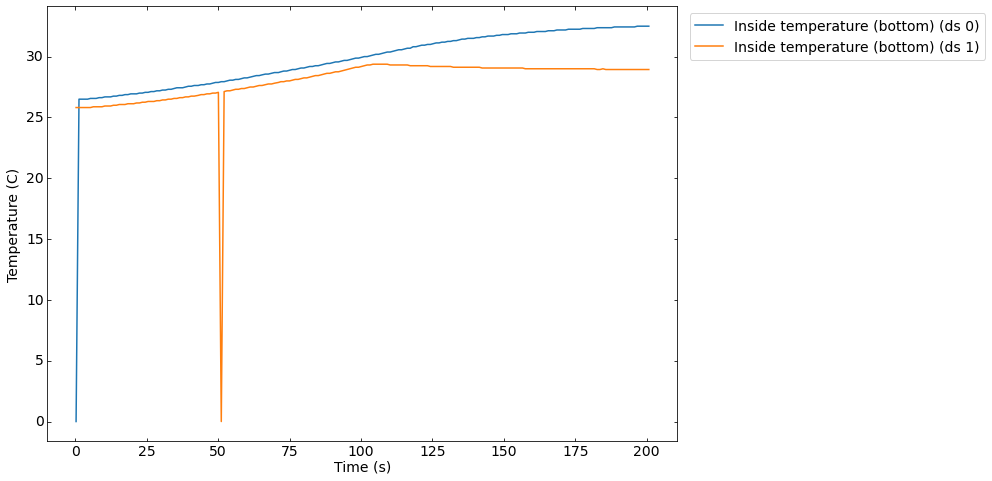

Data saved to:
./data_saves/save_data0.csv
Data saved to:
./data_saves/save_data1.csv


In [23]:
# Other parameters
num_points = 200     # number of loops, and number of temperature readings
data_size = 10      # number of points in a data frame
delay_loop = 1       # time in seconds for each loop

####################################################
# graph parameters
plot_mask = [1,0,0,0,0,0,0,0,0,0]
label_array = ["Inside temperature (bottom)", "Inside temperature (top)", "Outside temperature", "CO2 concentration",
               "Humidity RH inside", "Heater current","Heater voltage","Set point temperature","H2 TVOC raw reading",
              "EthOH TVOC raw reading"]
axis_assignment = [0,0,0,1,2,3,4,0,5,6]
y_axis_labels = ["Temperature (C)","CO2 concentration (ppm)","Relative Humidity (%)","Current (A)","Voltage (V)",
                 "H2 TVOC reading (arb)","EthOH TVOC reading (arb)"]
####################################################
#Setup arrays
last_data_point_box_1 = np.zeros(data_size)
last_data_point_box_2 = np.zeros(data_size)

data_array_array = np.zeros([2,num_points,data_size])
time_array_array = np.zeros([2,num_points])


####################################################
tic = time.time()
start_tic = tic
for i in range(0,num_points):
    
    if(i==0):
        box_1.write("(17,1)".encode()); # Heater fan on 
        box_1.write("(18,1)".encode()); # Heater on 
        box_1.write("(16,1)".encode()); # Cooling fan on
        
        box_2.write("(17,1)".encode()); # Heater fan on 
        box_2.write("(18,1)".encode()); # Heater on
        box_2.write("(16,0)".encode()); # Cooling fan off
    if(i==100):
        box_1.write("(17,1)".encode()); # Heater fan on 
        box_1.write("(18,0)".encode()); # Heater off
        box_1.write("(16,1)".encode()); # Cooling fan on
        
        box_2.write("(17,0)".encode()); # Heater fan off 
        box_2.write("(18,0)".encode()); # Heater off
        box_2.write("(16,0)".encode()); # Cooling fan off
    
    
    tic = time.time()
    current_data = read_data(box_1,last_data_point_box_1,delay_loop)
    data_array_array[0,i] = current_data
    current_data = read_data(box_2,last_data_point_box_2,delay_loop)
    data_array_array[1,i] = current_data
    
    toc = time.time()
    time_array_array[:,i] = toc-start_tic
    
    plot_data_multi_plot(label_array,axis_assignment,y_axis_labels,plot_mask,data_array_array,time_array_array,0,i,1)
    while(toc-tic<delay_loop):
        toc = time.time()
        
file_name_counter = save_file(file_name_counter,data_array_array[0],time_array_array[0])
file_name_counter = save_file(file_name_counter,data_array_array[1],time_array_array[1])
box_1.write("(16,1)".encode()); # Turn on cooling fan
box_2.write("(16,1)".encode()); # Turn on cooling fan
box_1.write("(17,1)".encode()); # Turn on heater fan
box_2.write("(17,1)".encode()); # Turn on heater fan
box_1.write("(18,0)".encode()); # Turn off heater
box_2.write("(18,0)".encode()); # Turn off heater

## Part A: Implementing PID controller

### The proportional term

Complete the code that is sectioned off with ######. You need to define the 5 variables that are missing a statement on the right side of the equals sign. The comments provide a hint as to what needs to be defined. Once you define this you will have to copy that part of the code to the remaining corresponding sections.

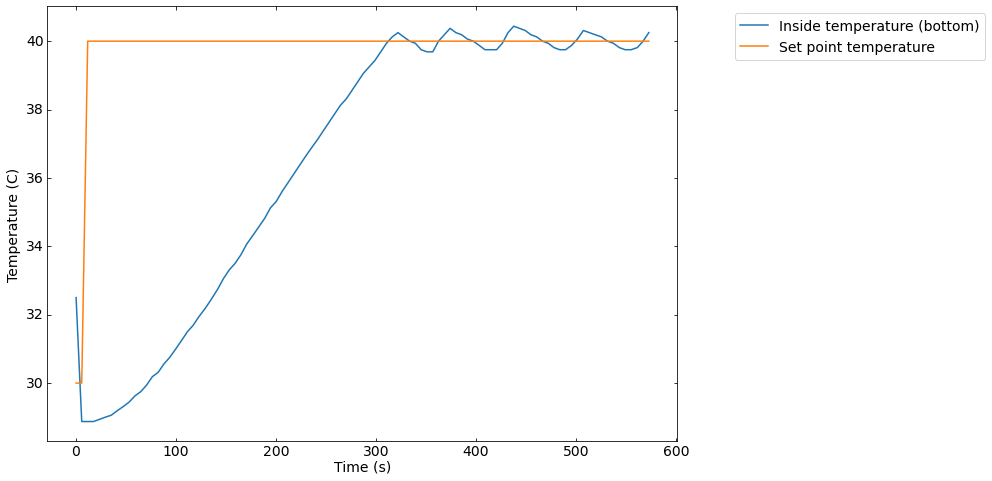

Data saved to:
./data_saves/save_data2.csv


In [24]:
set_point = 40      # set point for PID controller
k_p = 20            
k_i = 0
k_d = 0
delta_t = 3

# Other parameters
num_points = 100    # number of loops, and number of temperature readings
data_size = 10      # number of points in a data frame
delay_loop = delta_t      # time in seconds for each loop

####################################################
# graph parameters
plot_mask = [1,0,0,0,0,0,0,1,0,0]
label_array = ["Inside temperature (bottom)", "Inside temperature (top)", "Outside temperature", "CO2 concentration",
               "Humidity RH inside", "Heater current","Heater voltage","Set point temperature","H2 TVOC raw reading",
              "EthOH TVOC raw reading"]
axis_assignment = [0,0,0,1,2,3,4,0,5,6]
y_axis_labels = ["Temperature (C)","CO2 concentration (ppm)","Relative Humidity (%)","Current (A)","Voltage (V)",
                 "H2 TVOC reading (arb)","EthOH TVOC reading (arb)"]
#Setup arrays
last_data_point_box_1 = np.zeros(data_size)

data_array = np.zeros([num_points,data_size])
time_array = np.zeros([num_points])
set_point_cmd = "(8,"+str(set_point)+")"
box_1.write(set_point_cmd.encode()); # Turn on cooling fan

tic = time.time()
start_tic = tic
error_i = 0
past_error = 0
for i in range(0,num_points):
    delta_t = toc-tic # delta_t can change a little
    tic = time.time()
    current_data = read_data(box_1,last_data_point_box_1,delay_loop)
    data_array[i] = current_data
    toc = time.time()
    time_array[i] = toc-start_tic
#######################################################################################
    current_inside_temperature = current_data[0]
    #Put solution for rest of PID controller here
    #use the set_point and current_inside_temperature to define:
    #error, the derivative of error (error_d) and the integral of error (error_i)
    error = set_point - current_inside_temperature #use set_point, and current_inside_temperature
    delta_error = error - past_error      #use past_error and error
    error_d = delta_error / delta_t          #use delta_error, and delta_t
    error_i = error_i + (error * delta_t)         #use error_i and error
    #Now define the pid_output using your error and PID coefficients. This will control the heater 
    pid_output = (k_p * error) + (k_i * error_i) + (k_d * error_d)     # use what you defined above and k_p k_d and k_i
    #Lastly for the derivative we need to save the error, so we can compute delta_error
    past_error = error
#######################################################################################        
    plot_data(label_array,axis_assignment,y_axis_labels,plot_mask,data_array,time_array,0,i,1)
    counter = 0
    while(counter < 5):
        if(pid_output > 1):
            box_1.write("(17,1)".encode()); # Heater fan on 
            box_1.write("(18,1)".encode()); # Heater on
            box_1.write("(16,0)".encode()); # Cooling fan off
            pid_output = pid_output - 1
        elif(1>pid_output>-1):
            if(counter == 0):
                if(1>pid_output>0):
                    box_1.write("(17,1)".encode()); # Heater fan on 
                    box_1.write("(18,1)".encode()); # Heater on
                    box_1.write("(16,0)".encode()); # Cooling fan off
                elif(pid_output == 0):
                    box_1.write("(17,0)".encode()); # Heater fan off 
                    box_1.write("(18,0)".encode()); # Heater off
                    box_1.write("(16,0)".encode()); # Cooling fan off
                elif(-1<pid_output<0):
                    box_1.write("(17,0)".encode()); # Heater fan off 
                    box_1.write("(18,0)".encode()); # Heater off
                    box_1.write("(16,1)".encode()); # Cooling fan on
            else:
                box_1.write("(17,0)".encode()); # Heater fan off 
                box_1.write("(18,0)".encode()); # Heater off
                box_1.write("(16,0)".encode()); # Cooling fan off
        elif(pid_output<-1):
            box_1.write("(17,0)".encode()); # Heater fan off 
            box_1.write("(18,0)".encode()); # Heater off
            box_1.write("(16,1)".encode()); # Cooling fan on
            pid_output = pid_output + 1
        else:
            keep_looping = 0
        time.sleep(1)
        counter = counter + 1
    while(toc-tic<delay_loop): # wait for the loop time to finish
        toc = time.time()
box_1.write("(16,1)".encode()); # Turn on cooling fan
box_1.write("(17,1)".encode()); # Turn on heater fan
box_1.write("(18,0)".encode()); # Turn off heater
file_name_counter = save_file(file_name_counter,data_array,time_array)

In [26]:
# if you need to restart the loop cool down the box using the fans before starting, 
# so that there is some initial error to correct
box_1.write("(16,1)".encode()); # Turn on cooling fan
box_1.write("(17,1)".encode()); # Turn on heater fan
box_1.write("(18,0)".encode()); # Turn off heater

Let's let the temperature drop to around 34 degrees. This is because now we will adjust the proprotional gain to a low value, so we want to be pretty close to the setpoint to observe the effect

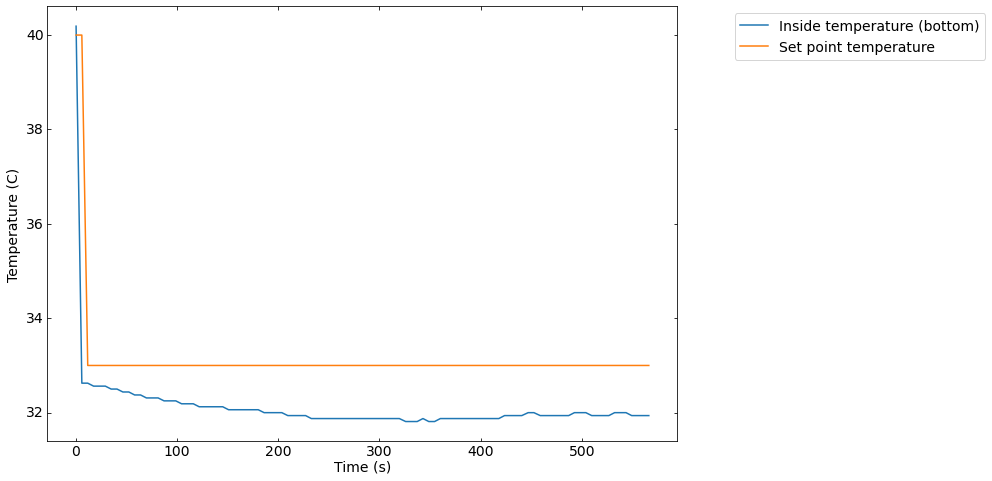

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:37<00:00,  5.78s/it]

Data saved to:
./data_saves/save_data3.csv


In [27]:
set_point = 33      # set point for PID controller
k_p = 1             
k_i = 0
k_d = 0
delta_t = 3

# Other parameters
num_points = 100    # number of loops, and number of temperature readings
data_size = 10      # number of points in a data frame
delay_loop = delta_t      # time in seconds for each loop

####################################################
# graph parameters
plot_mask = [1,0,0,0,0,0,0,1,0,0]
label_array = ["Inside temperature (bottom)", "Inside temperature (top)", "Outside temperature", "CO2 concentration",
               "Humidity RH inside", "Heater current","Heater voltage","Set point temperature","H2 TVOC raw reading",
              "EthOH TVOC raw reading"]
axis_assignment = [0,0,0,1,2,3,4,0,5,6]
y_axis_labels = ["Temperature (C)","CO2 concentration (ppm)","Relative Humidity (%)","Current (A)","Voltage (V)",
                 "H2 TVOC reading (arb)","EthOH TVOC reading (arb)"]
#Setup arrays
last_data_point_box_1 = np.zeros(data_size)

data_array = np.zeros([num_points,data_size])
time_array = np.zeros([num_points])
set_point_cmd = "(8,"+str(set_point)+")"
box_1.write(set_point_cmd.encode()); # Turn on cooling fan

tic = time.time()
start_tic = tic
error_i = 0
past_error = 0
for i in tqdm(range(0,num_points)):
    delta_t = toc-tic # delta_t can change a little
    tic = time.time()
    current_data = read_data(box_1,last_data_point_box_1,delay_loop)
    data_array[i] = current_data
    toc = time.time()
    time_array[i] = toc-start_tic
#######################################################################################
    current_inside_temperature = current_data[0]
    #Put solution for rest of PID controller here
    #use the set_point and current_inside_temperature to define:
    #error, the derivative of error (error_d) and the integral of error (error_i)
    error = set_point - current_inside_temperature #use set_point, and current_inside_temperature
    delta_error = error - past_error      #use past_error and error
    error_d = delta_error / delta_t          #use delta_error, and delta_t
    error_i = error_i + (error * delta_t)         #use error_i and error
    #Now define the pid_output using your error and PID coefficients. This will control the heater 
    pid_output = (k_p * error) + (k_i * error_i) + (k_d * error_d)     # use what you defined above and k_p k_d and k_i
    #Lastly for the derivative we need to save the error, so we can compute delta_error
    past_error = error
#######################################################################################      
    plot_data(label_array,axis_assignment,y_axis_labels,plot_mask,data_array,time_array,0,i,1)
    counter = 0
    while(counter < 5):
        if(pid_output > 1):
            box_1.write("(17,1)".encode()); # Heater fan on 
            box_1.write("(18,1)".encode()); # Heater on
            box_1.write("(16,0)".encode()); # Cooling fan off
            pid_output = pid_output - 1
        elif(1>pid_output>-1):
            if(counter == 0):
                if(1>pid_output>0):
                    box_1.write("(17,1)".encode()); # Heater fan on 
                    box_1.write("(18,1)".encode()); # Heater on
                    box_1.write("(16,0)".encode()); # Cooling fan off
                elif(pid_output == 0):
                    box_1.write("(17,0)".encode()); # Heater fan off 
                    box_1.write("(18,0)".encode()); # Heater off
                    box_1.write("(16,0)".encode()); # Cooling fan off
                elif(-1<pid_output<0):
                    box_1.write("(17,0)".encode()); # Heater fan off 
                    box_1.write("(18,0)".encode()); # Heater off
                    box_1.write("(16,1)".encode()); # Cooling fan on
            else:
                box_1.write("(17,0)".encode()); # Heater fan off 
                box_1.write("(18,0)".encode()); # Heater off
                box_1.write("(16,0)".encode()); # Cooling fan off
        elif(pid_output<-1):
            box_1.write("(17,0)".encode()); # Heater fan off 
            box_1.write("(18,0)".encode()); # Heater off
            box_1.write("(16,1)".encode()); # Cooling fan on
            pid_output = pid_output + 1
        else:
            keep_looping = 0
        time.sleep(1)
        counter = counter + 1
    while(toc-tic<delay_loop): # wait for the loop time to finish
        toc = time.time()
box_1.write("(16,1)".encode()); # Turn on cooling fan
box_1.write("(17,1)".encode()); # Turn on heater fan
box_1.write("(18,0)".encode()); # Turn off heater
file_name_counter = save_file(file_name_counter,data_array,time_array)

### The derivative coefficient 

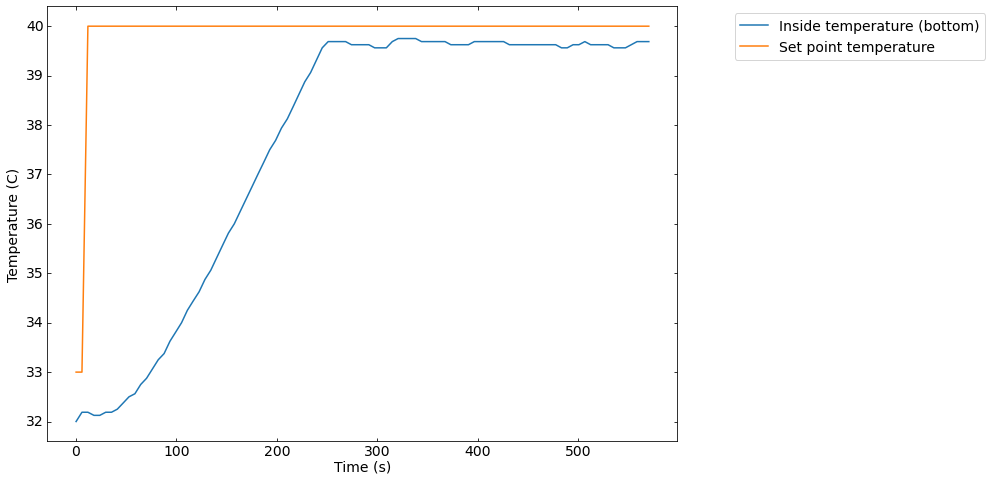

Data saved to:
./data_saves/save_data4.csv


In [28]:
set_point = 40      # set point for PID controller
k_p = 5             
k_i = 0
k_d = 10
delta_t = 3

# Other parameters
num_points = 100    # number of loops, and number of temperature readings
data_size = 10      # number of points in a data frame
delay_loop = delta_t      # time in seconds for each loop

####################################################
# graph parameters
plot_mask = [1,0,0,0,0,0,0,1,0,0]
label_array = ["Inside temperature (bottom)", "Inside temperature (top)", "Outside temperature", "CO2 concentration",
               "Humidity RH inside", "Heater current","Heater voltage","Set point temperature","H2 TVOC raw reading",
              "EthOH TVOC raw reading"]
axis_assignment = [0,0,0,1,2,3,4,0,5,6]
y_axis_labels = ["Temperature (C)","CO2 concentration (ppm)","Relative Humidity (%)","Current (A)","Voltage (V)",
                 "H2 TVOC reading (arb)","EthOH TVOC reading (arb)"]
#Setup arrays
last_data_point_box_1 = np.zeros(data_size)

data_array = np.zeros([num_points,data_size])
time_array = np.zeros([num_points])
set_point_cmd = "(8,"+str(set_point)+")"
box_1.write(set_point_cmd.encode()); # Turn on cooling fan

tic = time.time()
start_tic = tic
error_i = 0
past_error = 0
for i in range(0,num_points):
    delta_t = toc-tic # delta_t can change a little
    tic = time.time()
    current_data = read_data(box_1,last_data_point_box_1,delay_loop)
    data_array[i] = current_data
    toc = time.time()
    time_array[i] = toc-start_tic
#######################################################################################
    current_inside_temperature = current_data[0]
    #Put solution for rest of PID controller here
    #use the set_point and current_inside_temperature to define:
    #error, the derivative of error (error_d) and the integral of error (error_i)
    error = set_point - current_inside_temperature #use set_point, and current_inside_temperature
    delta_error = error - past_error      #use past_error and error
    error_d = delta_error / delta_t          #use delta_error, and delta_t
    error_i = error_i + (error * delta_t)         #use error_i and error
    #Now define the pid_output using your error and PID coefficients. This will control the heater 
    pid_output = (k_p * error) + (k_i * error_i) + (k_d * error_d)     # use what you defined above and k_p k_d and k_i
    #Lastly for the derivative we need to save the error, so we can compute delta_error
    past_error = error
#######################################################################################               
    plot_data(label_array,axis_assignment,y_axis_labels,plot_mask,data_array,time_array,0,i,1)
    counter = 0
    while(counter < 5):
        if(pid_output > 1):
            box_1.write("(17,1)".encode()); # Heater fan on 
            box_1.write("(18,1)".encode()); # Heater on
            box_1.write("(16,0)".encode()); # Cooling fan off
            pid_output = pid_output - 1
        elif(1>pid_output>-1):
            if(counter == 0):
                if(1>pid_output>0):
                    box_1.write("(17,1)".encode()); # Heater fan on 
                    box_1.write("(18,1)".encode()); # Heater on
                    box_1.write("(16,0)".encode()); # Cooling fan off
                elif(pid_output == 0):
                    box_1.write("(17,0)".encode()); # Heater fan off 
                    box_1.write("(18,0)".encode()); # Heater off
                    box_1.write("(16,0)".encode()); # Cooling fan off
                elif(-1<pid_output<0):
                    box_1.write("(17,0)".encode()); # Heater fan off 
                    box_1.write("(18,0)".encode()); # Heater off
                    box_1.write("(16,1)".encode()); # Cooling fan on
            else:
                box_1.write("(17,0)".encode()); # Heater fan off 
                box_1.write("(18,0)".encode()); # Heater off
                box_1.write("(16,0)".encode()); # Cooling fan off
        elif(pid_output<-1):
            box_1.write("(17,0)".encode()); # Heater fan off 
            box_1.write("(18,0)".encode()); # Heater off
            box_1.write("(16,1)".encode()); # Cooling fan on
            pid_output = pid_output + 1
        else:
            keep_looping = 0
        time.sleep(1)
        counter = counter + 1
    while(toc-tic<delay_loop): # wait for the loop time to finish
        toc = time.time()
box_1.write("(16,1)".encode()); # Turn on cooling fan
box_1.write("(17,1)".encode()); # Turn on heater fan
box_1.write("(18,0)".encode()); # Turn off heater
file_name_counter = save_file(file_name_counter,data_array,time_array)

### The integral coefficient

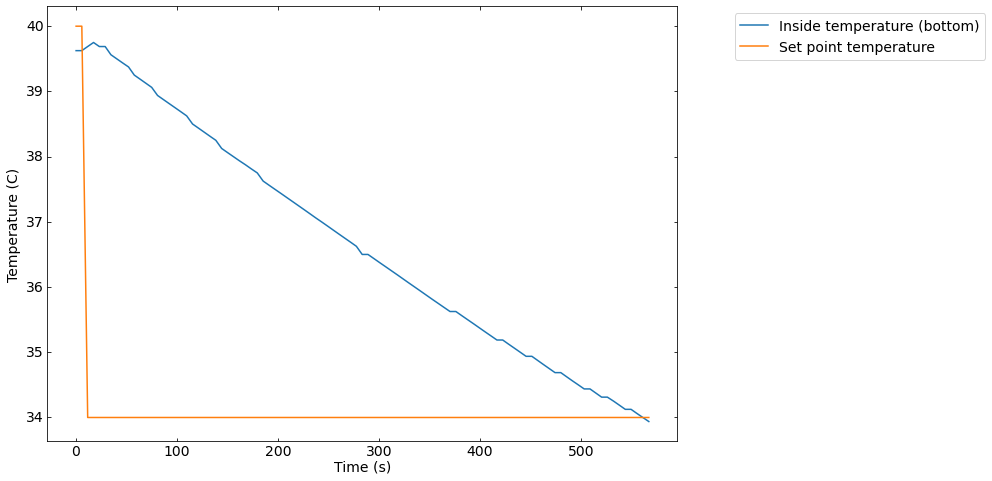

Data saved to:
./data_saves/save_data5.csv


In [29]:
set_point = 34      # set point for PID controller
k_p = 5             
k_i = 0.5
k_d = 10
delta_t = 3

# Other parameters
num_points = 100    # number of loops, and number of temperature readings
data_size = 10      # number of points in a data frame
delay_loop = delta_t      # time in seconds for each loop

####################################################
# graph parameters
plot_mask = [1,0,0,0,0,0,0,1,0,0]
label_array = ["Inside temperature (bottom)", "Inside temperature (top)", "Outside temperature", "CO2 concentration",
               "Humidity RH inside", "Heater current","Heater voltage","Set point temperature","H2 TVOC raw reading",
              "EthOH TVOC raw reading"]
axis_assignment = [0,0,0,1,2,3,4,0,5,6]
y_axis_labels = ["Temperature (C)","CO2 concentration (ppm)","Relative Humidity (%)","Current (A)","Voltage (V)",
                 "H2 TVOC reading (arb)","EthOH TVOC reading (arb)"]
#Setup arrays
last_data_point_box_1 = np.zeros(data_size)

data_array = np.zeros([num_points,data_size])
time_array = np.zeros([num_points])
set_point_cmd = "(8,"+str(set_point)+")"
box_1.write(set_point_cmd.encode()); # Turn on cooling fan

tic = time.time()
start_tic = tic
error_i = 0
past_error = 0
for i in range(0,num_points):
    delta_t = toc-tic # delta_t can change a little
    tic = time.time()
    current_data = read_data(box_1,last_data_point_box_1,delay_loop)
    data_array[i] = current_data
    toc = time.time()
    time_array[i] = toc-start_tic
#######################################################################################
    current_inside_temperature = current_data[0]
    #Put solution for rest of PID controller here
    #use the set_point and current_inside_temperature to define:
    #error, the derivative of error (error_d) and the integral of error (error_i)
    error = set_point - current_inside_temperature #use set_point, and current_inside_temperature
    delta_error = error - past_error      #use past_error and error
    error_d = delta_error / delta_t          #use delta_error, and delta_t
    error_i = error_i + (error * delta_t)         #use error_i and error
    #Now define the pid_output using your error and PID coefficients. This will control the heater 
    pid_output = (k_p * error) + (k_i * error_i) + (k_d * error_d)     # use what you defined above and k_p k_d and k_i
    #Lastly for the derivative we need to save the error, so we can compute delta_error
    past_error = error
#######################################################################################              
    plot_data(label_array,axis_assignment,y_axis_labels,plot_mask,data_array,time_array,0,i,1)
    counter = 0
    while(counter < 5):
        if(pid_output > 1):
            box_1.write("(17,1)".encode()); # Heater fan on 
            box_1.write("(18,1)".encode()); # Heater on
            box_1.write("(16,0)".encode()); # Cooling fan off
            pid_output = pid_output - 1
        elif(1>pid_output>-1):
            if(counter == 0):
                if(1>pid_output>0):
                    box_1.write("(17,1)".encode()); # Heater fan on 
                    box_1.write("(18,1)".encode()); # Heater on
                    box_1.write("(16,0)".encode()); # Cooling fan off
                elif(pid_output == 0):
                    box_1.write("(17,0)".encode()); # Heater fan off 
                    box_1.write("(18,0)".encode()); # Heater off
                    box_1.write("(16,0)".encode()); # Cooling fan off
                elif(-1<pid_output<0):
                    box_1.write("(17,0)".encode()); # Heater fan off 
                    box_1.write("(18,0)".encode()); # Heater off
                    box_1.write("(16,1)".encode()); # Cooling fan on
            else:
                box_1.write("(17,0)".encode()); # Heater fan off 
                box_1.write("(18,0)".encode()); # Heater off
                box_1.write("(16,0)".encode()); # Cooling fan off
        elif(pid_output<-1):
            box_1.write("(17,0)".encode()); # Heater fan off 
            box_1.write("(18,0)".encode()); # Heater off
            box_1.write("(16,1)".encode()); # Cooling fan on
            pid_output = pid_output + 1
        else:
            keep_looping = 0
        time.sleep(1)
        counter = counter + 1
    while(toc-tic<delay_loop): # wait for the loop time to finish
        toc = time.time()
box_1.write("(16,1)".encode()); # Turn on cooling fan
box_1.write("(17,1)".encode()); # Turn on heater fan
box_1.write("(18,0)".encode()); # Turn off heater
file_name_counter = save_file(file_name_counter,data_array,time_array)

## Part B: CO2 measurement at two different temperatures

Let us set the temperature of one box to 30 and the other to 45. 

In [30]:
box_1.write("(2,0)".encode()); # enter PID mode
box_2.write("(2,0)".encode()); # enter PID mode

box_1.write("(22,7)".encode()); # Set system loop update speed to 7*0.1+0.3 = 1 second
box_2.write("(22,7)".encode()); # Set system loop update speed to 7*0.1+0.3 = 1 second

box_1.write("(8,30)".encode()); # Set PID set point to 30 C
box_2.write("(8,45)".encode()); # Set PID set point to 45 C

Now execute the following code to start the CO2 measurements along with the temperature readings. Wait for the temperature inside the boxes to reach the set point. Then blow on both of the boxes to observe a spike in the CO2 concentrations. Use this data for Part B of your report. (If the detector saturates or the peak is not significant enough, trying again  to get proper data for analysis). 

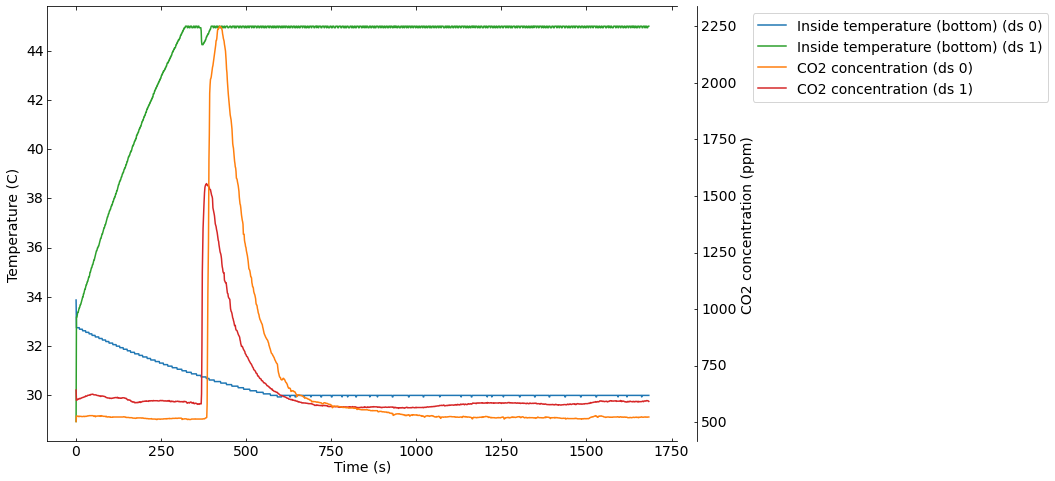

Data saved to:
./data_saves/save_data106.csv
Data saved to:
./data_saves/save_data107.csv


In [31]:
# Other parameters
num_points = 1500     # number of loops, and number of temperature readings
data_size = 10      # number of points in a data frame
delay_loop = 1       # time in seconds for each loop

####################################################
# graph parameters
plot_mask = [1,0,0,1,0,0,0,0,0,0]
label_array = ["Inside temperature (bottom)", "Inside temperature (top)", "Outside temperature", "CO2 concentration",
               "Humidity RH inside", "Heater current","Heater voltage","Set point temperature","H2 TVOC raw reading",
              "EthOH TVOC raw reading"]
axis_assignment = [0,0,0,1,2,3,4,0,5,6]
y_axis_labels = ["Temperature (C)","CO2 concentration (ppm)","Relative Humidity (%)","Current (A)","Voltage (V)",
                 "H2 TVOC reading (arb)","EthOH TVOC reading (arb)"]
####################################################
#Setup arrays
last_data_point_box_1 = np.zeros(data_size)
last_data_point_box_2 = np.zeros(data_size)

data_array_array = np.zeros([2,num_points,data_size])
time_array_array = np.zeros([2,num_points])


####################################################
tic = time.time()
start_tic = tic
for i in range(0,num_points):
    
    if(i==0):
        box_1.write("(8,30)".encode()); # Set PID set point to 30 C
        box_2.write("(8,45)".encode()); # Set PID set point to 45 C

    tic = time.time()
    current_data = read_data(box_1,last_data_point_box_1,delay_loop)
    last_data_point_box_1 = current_data
    data_array_array[0,i] = current_data
    current_data = read_data(box_2,last_data_point_box_2,delay_loop)
    data_array_array[1,i] = current_data
    last_data_point_box_2 = current_data
    
    toc = time.time()
    time_array_array[:,i] = toc-start_tic
    
    plot_data_multi_plot(label_array,axis_assignment,y_axis_labels,plot_mask,data_array_array,time_array_array,0,i,1)
    while(toc-tic<delay_loop):
        toc = time.time()

box_1.write("(18,0)".encode()); # Turn off heater
box_2.write("(18,0)".encode()); # Turn off heater
file_name_counter = 100+file_name_counter
plot_a_number = file_name_counter
file_name_counter = save_file(file_name_counter,data_array_array[0],time_array_array[0])
plot_b_number = file_name_counter
file_name_counter = save_file(file_name_counter,data_array_array[1],time_array_array[1])

In [32]:
box_1.close()
box_2.close()